In [17]:
# # CL0.5 — 如果存在已缓存的处理数据，直接复用（可选）
# import json
# from pathlib import Path

# CACHE_DIR = Path("data/processed_v1")
# train_path = CACHE_DIR / "train_fe.parquet"
# test_path  = CACHE_DIR / "test_fe.parquet"
# meta_path  = CACHE_DIR / "meta.json"

# _use_cache = train_path.exists() and test_path.exists() and meta_path.exists()
# if _use_cache:
#     train_fe = pd.read_parquet(train_path)
#     test_fe  = pd.read_parquet(test_path)
#     with open(meta_path, "r", encoding="utf-8") as f:
#         meta = json.load(f)
#     features = meta["features"]
#     cat_features = meta["cat_features"]

#     # 恢复类别 dtype（parquet 读回可能是字符串/整数）
#     for c in cat_features:
#         if c in train_fe.columns:
#             train_fe[c] = train_fe[c].astype("category")
#         if c in test_fe.columns:
#             test_fe[c] = test_fe[c].astype("category")

#     print(f"[cache] loaded processed data from {CACHE_DIR}")
# else:
#     print("[cache] processed data not found — continue with CL1–CL6 to build features.")

In [18]:
# Cell 1 — 读取数据（并快速查看基本信息）

# 如果你已安装好依赖，这里无需再装；没装的话取消下一行注释：
# !pip install -U pandas numpy

import pandas as pd
import numpy as np

# —— 路径设置（如你的文件名/路径不同，改这里即可）——
TRAIN_PATH = "data/train.csv"
TEST_PATH  = "data/testA.csv"

# 读取（关闭低内存模式，避免把同一列读成混合类型）
train = pd.read_csv(TRAIN_PATH, low_memory=False)
test  = pd.read_csv(TEST_PATH,  low_memory=False)

print(f"train.shape = {train.shape} | test.shape = {test.shape}")
print("train columns:", list(train.columns))
print("test  columns:", list(test.columns))

# 目标列存在性检查（竞赛通常目标是 isDefault）
if "isDefault" in train.columns:
    pos_rate = train["isDefault"].mean()
    print(f"isDefault 正样本比例（训练集）= {pos_rate:.4f}")
else:
    print("⚠️ 训练集中未发现目标列 isDefault，请确认数据。")

# 快速预览前几行
display(train.head(3))
display(test.head(3))

train.shape = (800000, 47) | test.shape = (200000, 46)
train columns: ['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade', 'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership', 'annualIncome', 'verificationStatus', 'issueDate', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'earliesCreditLine', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
test  columns: ['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade', 'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership', 'annualIncome', 'verificationStatus', 'issueDate', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'tota

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0


,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,800000,14000.0,3,10.99,458.28,B,B3,7027.0,10+ years,0,...,8.0,4.0,15.0,19.0,6.0,17.0,0.0,0.0,1.0,3.0
1,800001,20000.0,5,14.65,472.14,C,C5,60426.0,10+ years,0,...,1.0,3.0,3.0,9.0,3.0,5.0,0.0,0.0,2.0,2.0
2,800002,12000.0,3,19.99,445.91,D,D4,23547.0,2 years,1,...,1.0,36.0,5.0,6.0,4.0,12.0,0.0,0.0,0.0,7.0


dtypes：
id                      int64
loanAmnt              float64
term                    int64
interestRate          float64
installment           float64
grade                  object
subGrade               object
employmentTitle       float64
employmentLength       object
homeOwnership           int64
annualIncome          float64
verificationStatus      int64
issueDate              object
isDefault               int64
purpose                 int64
postCode              float64
regionCode              int64
dti                   float64
delinquency_2years    float64
ficoRangeLow          float64
ficoRangeHigh         float64
openAcc               float64
pubRec                float64
pubRecBankruptcies    float64
revolBal              float64
revolUtil             float64
totalAcc              float64
initialListStatus       int64
applicationType         int64
earliesCreditLine      object
title                 float64
policyCode            float64
n0                    float64
n1

,missing_rate
n11,0.087190
employmentLength,0.058499
n8,0.050339
n6,0.050338
n12,0.050338
n9,0.050338
n13,0.050338
n14,0.050338
n5,0.050338
n0,0.050338


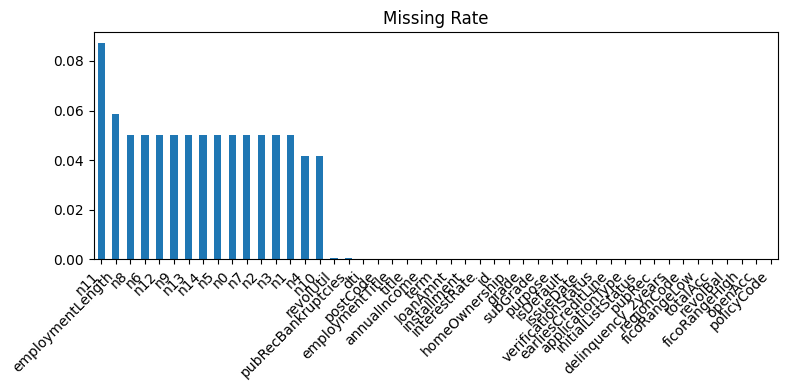

In [19]:
# Cell 2 — 基础信息 & 缺失值摸底

import matplotlib.pyplot as plt

assert "id" in train.columns, "数据应包含 id 列"
if "isDefault" not in train.columns:
    print("⚠️ 未发现 isDefault 目标列，请确认训练集。")

# 数据类型
print("dtypes：")
print(train.dtypes)

# 数值列 / 猜测的类别列（粗分）
num_cols = train.select_dtypes(include=["number"]).columns.tolist()
cat_guess = [c for c in train.columns if c not in num_cols + (["isDefault"] if "isDefault" in train.columns else [])]
print(f"#numeric={len(num_cols)}, #categorical_guess={len(cat_guess)}")
print("cat_guess 示例：", cat_guess[:10])

# 缺失率
na_rate = train.isna().mean().sort_values(ascending=False)
display(na_rate.to_frame("missing_rate"))

# 画缺失率
top_na = na_rate
plt.figure(figsize=(8,4))
top_na.plot(kind="bar")
plt.title("Missing Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

[Sample] 正样本比例 = 0.1995


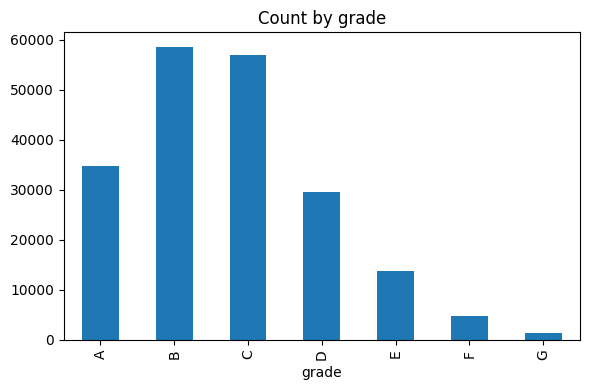

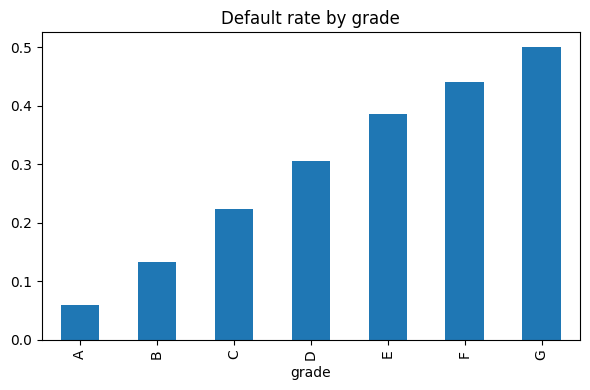

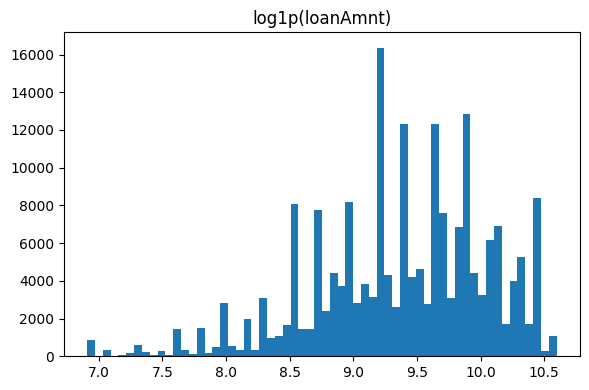

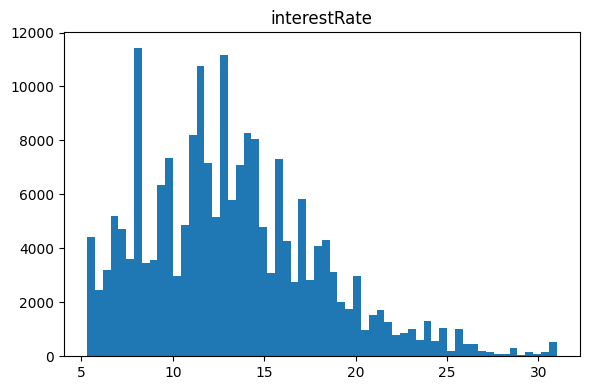

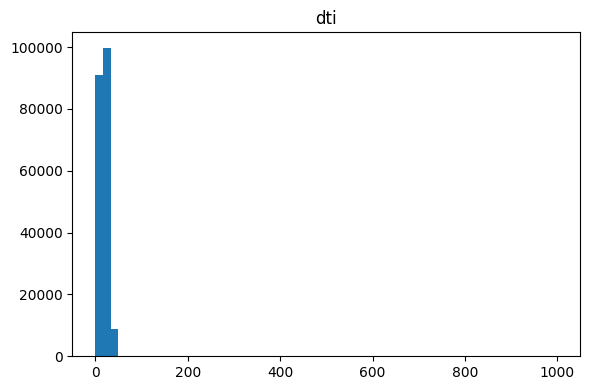

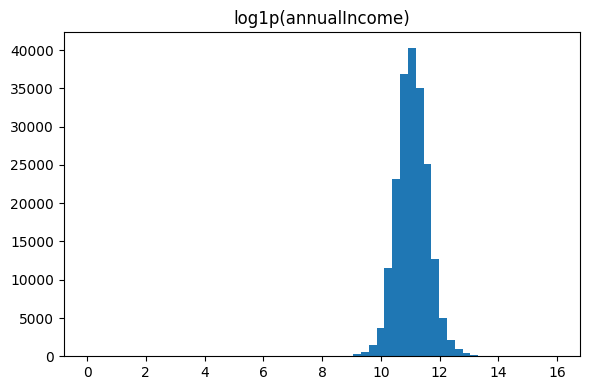

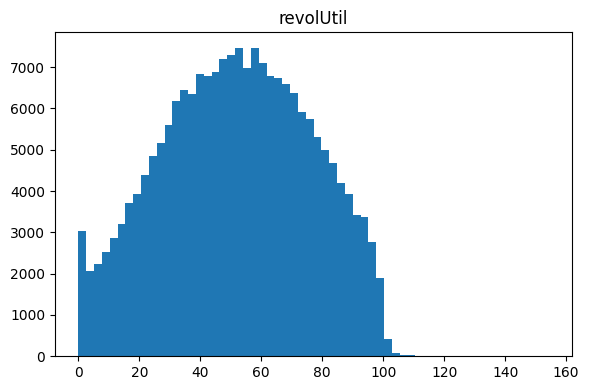

In [20]:
# Cell 3 — 轻量可视化（抽样，避免全量绘图过慢/占内存）

SAMPLE_N = min(200_000, len(train))
sample = train.sample(SAMPLE_N, random_state=2025)

# 目标分布
if "isDefault" in sample.columns:
    pos_rate = sample["isDefault"].mean()
    print(f"[Sample] 正样本比例 = {pos_rate:.4f}")

# 贷款等级数量 & 等级违约率
if "grade" in sample.columns and "isDefault" in sample.columns:
    cnt = sample["grade"].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    cnt.plot(kind="bar")
    plt.title("Count by grade")
    plt.tight_layout()
    plt.show()

    dr = sample.groupby("grade")["isDefault"].mean().sort_index()
    plt.figure(figsize=(6,4))
    dr.plot(kind="bar")
    plt.title("Default rate by grade")
    plt.tight_layout()
    plt.show()

# 常见关键数值分布
def safe_hist(s, title, bins=50, log=False):
    x = pd.to_numeric(s, errors="coerce")
    x = x[np.isfinite(x)]
    if log:
        x = np.log1p(x)
        title = f"log1p({title})"
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.tight_layout()
    plt.show()

for col, title, lg in [
    ("loanAmnt", "loanAmnt", True),
    ("interestRate", "interestRate", False),
    ("dti", "dti", False),
    ("annualIncome", "annualIncome", True),
    ("revolUtil", "revolUtil", False),
]:
    if col in sample.columns:
        safe_hist(sample[col], title, bins=60, log=lg)

In [21]:
# P0 — 进度条初始化（全局一次）
# 如果你没装 tqdm，请先执行：!pip install -U tqdm

from tqdm.auto import tqdm
tqdm.pandas()  # 让 pandas 的 .progress_apply() 可用

# 统一的进度条样式（可选）
tqdm_kwargs = dict(leave=False, dynamic_ncols=True, smoothing=0.1)

In [22]:
# Cell 4 — 工具函数（信息保全 + tqdm 版）

import re
import numpy as np
import pandas as pd

def reduce_mem_usage(df: pd.DataFrame, verbose=True, desc="Downcast columns"):
    start = df.memory_usage().sum() / 1024**2
    for col in tqdm(list(df.columns), desc=desc, **tqdm_kwargs):
        col_type = df[col].dtype
        if str(col_type).startswith(("int", "uint")):
            c_min, c_max = df[col].min(), df[col].max()
            if c_min >= 0:
                if c_max < np.iinfo(np.uint8).max:    df[col] = df[col].astype(np.uint8)
                elif c_max < np.iinfo(np.uint16).max: df[col] = df[col].astype(np.uint16)
                elif c_max < np.iinfo(np.uint32).max: df[col] = df[col].astype(np.uint32)
                else:                                  df[col] = df[col].astype(np.uint64)
            else:
                if np.iinfo(np.int8).min  < c_min < np.iinfo(np.int8).max:    df[col] = df[col].astype(np.int8)
                elif np.iinfo(np.int16).min < c_min < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif np.iinfo(np.int32).min < c_min < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
                else:                                                         df[col] = df[col].astype(np.int64)
        elif str(col_type).startswith("float"):
            df[col] = df[col].astype(np.float32)
    end = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"[reduce_mem_usage] {start:.2f} -> {end:.2f} MB")
    return df

# —— 解析器 —— #
def parse_employment_length(x):
    """'10+ years' / '3 years' / '< 1 year' / 'n/a' -> 年数（0..10）"""
    if pd.isna(x): return np.nan
    s = str(x).lower().strip()
    if s in ("n/a","na","none"): return np.nan
    if "10" in s: return 10.0
    if "<" in s:  return 0.0
    m = re.findall(r"\d+", s)
    return float(m[0]) if m else np.nan

def normalize_employment_length_token(x):
    """将原字符串规范化成有限枚举，便于当作 category 保留原貌信息"""
    if pd.isna(x): return "na"
    s = str(x).lower().strip()
    if s in ("n/a","na","none"): return "na"
    if "10" in s: return "10+"
    if "<" in s:  return "<1"
    m = re.findall(r"\d+", s)
    return m[0] if m else "na"

def parse_term_general(x):
    """term 转月：int 直接用；若 <=10 视为年×12；字符串同理"""
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        v = float(x)
        return v*12 if v <= 10 else v
    s = str(x).lower()
    m = re.findall(r"\d+", s)
    if not m: return np.nan
    n = float(m[0])
    return n*12 if "year" in s else n

def parse_month(s):
    """尽量鲁棒的日期解析：支持 2012/7/1, 2012-07, %b-%y 等"""
    if pd.isna(s): return pd.NaT
    s = str(s).strip()
    for fmt in ("%Y/%m/%d", "%Y-%m-%d", "%Y-%m", "%Y/%m", "%b-%y", "%b-%Y"):
        try:
            return pd.to_datetime(s, format=fmt)
        except Exception:
            continue
    return pd.to_datetime(s, errors="coerce")

# —— 编码器 —— #
def freq_encode(series: pd.Series):
    """频数编码（完全无监督：train+test 上统计，不用标签）"""
    vc = series.astype(str).value_counts(dropna=False)
    mapping = vc / vc.sum()
    return series.astype(str).map(mapping).astype("float32")

def to_3digit_postcode_str(series: pd.Series):
    """float/int 邮编前三位 -> 3 位字符串，保留 leading zeros"""
    s = series.astype(str).str.split(".").str[0]
    s = s.where(~s.isin(["nan","None","none","NaN"]), other="")
    return s.str.zfill(3)

# —— 匿名特征统计 —— #
def add_n_stats(df, n_cols):
    n_df = df[n_cols].apply(pd.to_numeric, errors="coerce")
    print("[n-stats] computing: sum/mean/max/std/nonzero/q25/q75 ...")
    df["n_sum"]      = n_df.sum(axis=1).astype("float32")
    df["n_mean"]     = n_df.mean(axis=1).astype("float32")
    df["n_max"]      = n_df.max(axis=1).astype("float32")
    df["n_std"]      = n_df.std(axis=1).astype("float32")
    df["n_nonzero"]  = (n_df > 0).sum(axis=1).astype("float32")
    df["n_q25"]      = n_df.quantile(0.25, axis=1).astype("float32")
    df["n_q75"]      = n_df.quantile(0.75, axis=1).astype("float32")
    return df

def safe_cut(series, bins, labels=None):
    """warnings 安静的分桶"""
    try:
        return pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    except Exception:
        return pd.Series(pd.Categorical([np.nan]*len(series)))

In [23]:
# Cell 5 — 合并 + 特征工程（信息保全 + tqdm 版）

# 合并（无监督处理保持一致）
train["__is_train__"] = 1
test["__is_train__"]  = 0
full = pd.concat([train, test], axis=0, ignore_index=True)
full = reduce_mem_usage(full, desc="Downcast (before FE)")

# ========= 1) 直接保留的数值列（后续可能 log/分桶） =========
# 你给的 dtypes 中以下列已是数值：loanAmnt, interestRate, installment, annualIncome, dti, ficoRangeLow/High,
# openAcc, pubRec, pubRecBankruptcies, revolBal, revolUtil, totalAcc, n0..n14, 等
# 若需要 winsorize 可在此处补充（先不做，避免信息损失）

# ========= 2) term（月） + 分桶 =========
if "term" in full.columns:
    tqdm.write("[FE] term → term_mon, term_bin")
    full["term_mon"] = full["term"].progress_apply(parse_term_general).astype("float32")
    # 简单三桶（可按数据分布微调）
    full["term_bin"] = safe_cut(full["term_mon"], bins=[-1, 36, 60, np.inf], labels=["<=36","37-60",">60"]).astype("category")

# ========= 3) employmentLength：数值 + 原始 category =========
if "employmentLength" in full.columns:
    tqdm.write("[FE] employmentLength → emp_len_year, employmentLength_cat")
    full["emp_len_year"] = full["employmentLength"].progress_apply(parse_employment_length).astype("float32")
    full["employmentLength_cat"] = full["employmentLength"].progress_apply(normalize_employment_length_token).astype("category")

# ========= 4) issueDate / earliesCreditLine：解析 + 原始保留 =========
if "issueDate" in full.columns:
    tqdm.write("[FE] issueDate → dt & year/month/quarter/ym + category copy")
    full["issueDate_cat"] = full["issueDate"].astype(str).astype("category")
    full["issueDate_dt"] = full["issueDate"].progress_apply(parse_month)
    full["issue_year"]    = full["issueDate_dt"].dt.year.astype("float32")
    full["issue_month"]   = full["issueDate_dt"].dt.month.astype("float32")
    full["issue_quarter"] = full["issueDate_dt"].dt.quarter.astype("float32")
    full["issue_ym"]      = (full["issue_year"]*100 + full["issue_month"]).astype("float32")

if "earliesCreditLine" in full.columns:
    tqdm.write("[FE] earliesCreditLine → earliest_dt + category copy")
    full["earliesCreditLine_cat"] = full["earliesCreditLine"].astype(str).astype("category")
    full["earliest_dt"] = full["earliesCreditLine"].progress_apply(parse_month)

# 信用历史长度（月）
if {"issueDate_dt","earliest_dt"}.issubset(full.columns):
    tqdm.write("[FE] credit_hist_mon")
    diff_days = (full["issueDate_dt"] - full["earliest_dt"]).dt.days
    full["credit_hist_mon"] = (diff_days/30.0).astype("float32")

# ========= 5) FICO 衍生 =========
if {"ficoRangeLow","ficoRangeHigh"}.issubset(full.columns):
    tqdm.write("[FE] fico_mean, fico_diff")
    full["fico_mean"] = ((full["ficoRangeLow"] + full["ficoRangeHigh"]) / 2.0).astype("float32")
    full["fico_diff"] = (full["ficoRangeHigh"] - full["ficoRangeLow"]).astype("float32")
    # 可选：粗桶（按经验分段，后续可改分位数桶）
    # bins = [-np.inf, 580, 620, 660, 700, 740, np.inf]
    # full["fico_bin"] = pd.cut(full["fico_mean"], bins=bins).astype("category")

# ========= 6) 比率与组合 =========
if {"loanAmnt","annualIncome"}.issubset(full.columns):
    full["loan_income_ratio"] = (full["loanAmnt"] / (full["annualIncome"] + 1.0)).astype("float32")
if {"installment","annualIncome"}.issubset(full.columns):
    full["installment_income_ratio"] = (full["installment"] / (full["annualIncome"]/12.0 + 1e-6)).astype("float32")
if {"revolBal","openAcc"}.issubset(full.columns):
    full["revol_bal_per_acc"] = (full["revolBal"] / (full["openAcc"] + 1.0)).astype("float32")
if {"openAcc","totalAcc"}.issubset(full.columns):
    full["open_to_total"] = (full["openAcc"] / (full["totalAcc"] + 1.0)).astype("float32")

# ========= 7) 高基数：employmentTitle / title / postCode 双路保留 =========
# 你的 dtypes 中 employmentTitle、title 是 float；postCode 是 float
# 我们保留数值原列，同时做“字符串→category”和“频数编码”数值列
for col in ["employmentTitle", "title"]:
    if col in full.columns:
        tqdm.write(f"[FE] {col} → {col}_cat + {col}_freq")
        as_str = full[col].astype(str)  # 兼容 float 编码也当作类别
        full[f"{col}_cat"]  = as_str.astype("category")
        full[f"{col}_freq"] = freq_encode(as_str)

if "postCode" in full.columns:
    tqdm.write("[FE] postCode → postCode_cat + postCode_freq (3-digit str)")
    pc3 = to_3digit_postcode_str(full["postCode"])
    full["postCode_cat"]  = pc3.astype("category")
    full["postCode_freq"] = freq_encode(pc3)

# ========= 8) 低基数整型类别：转 category =========
low_card_int_as_cat = [
    "homeOwnership","verificationStatus","purpose","regionCode",
    "initialListStatus","applicationType","policyCode"
]
for c in tqdm([x for x in low_card_int_as_cat if x in full.columns],
              desc="Cast int-coded low-card to category", **tqdm_kwargs):
    full[c] = full[c].astype("category")

# ========= 9) 匿名特征 n0..n14：保留 + 统计 =========
n_cols = [c for c in [f"n{i}" for i in range(15)] if c in full.columns]
if n_cols:
    for c in tqdm(n_cols, desc="Cast n-cols to float32", **tqdm_kwargs):
        full[c] = pd.to_numeric(full[c], errors="coerce").astype("float32")
    full = add_n_stats(full, n_cols)

# ========= 10) 缺失与清理 =========
# 数值列缺失：用中位数；bool/分类不动；datetime 临时列删掉（我们保留了 *_cat）
num_cols_full = full.select_dtypes(include=["number"]).columns
full[num_cols_full] = full[num_cols_full].replace([np.inf, -np.inf], np.nan)
full[num_cols_full] = full[num_cols_full].fillna(full[num_cols_full].median())

for col in ["issueDate_dt","earliest_dt"]:
    if col in full.columns:
        full.drop(columns=[col], inplace=True)

full = reduce_mem_usage(full, desc="Downcast (after FE)")
print("[full] shape =", full.shape)
display(full.head(3))

Downcast (before FE):   0%|          | 0/48 [00:00<?, ?it/s]

[reduce_mem_usage] 366.21 -> 179.29 MB
[FE] term → term_mon, term_bin


  0%|          | 0/1000000 [00:00<?, ?it/s]

[FE] employmentLength → emp_len_year, employmentLength_cat


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

[FE] issueDate → dt & year/month/quarter/ym + category copy


  0%|          | 0/1000000 [00:00<?, ?it/s]

[FE] earliesCreditLine → earliest_dt + category copy


  0%|          | 0/1000000 [00:00<?, ?it/s]

[FE] credit_hist_mon
[FE] fico_mean, fico_diff
[FE] employmentTitle → employmentTitle_cat + employmentTitle_freq
[FE] title → title_cat + title_freq
[FE] postCode → postCode_cat + postCode_freq (3-digit str)


Cast int-coded low-card to category:   0%|          | 0/7 [00:00<?, ?it/s]

Cast n-cols to float32:   0%|          | 0/15 [00:00<?, ?it/s]

[n-stats] computing: sum/mean/max/std/nonzero/q25/q75 ...


Downcast (after FE):   0%|          | 0/78 [00:00<?, ?it/s]

[reduce_mem_usage] 291.20 -> 291.20 MB
[full] shape = (1000000, 78)


,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,title_freq,postCode_cat,postCode_freq,n_sum,n_mean,n_max,n_std,n_nonzero,n_q25,n_q75
0,0,35000.0,5,19.52,917.969971,E,E2,320.0,2 years,2,...,0.008687,137,0.002646,54.0,3.6,12.0,3.737838,11.0,1.00,5.50
1,1,18000.0,5,18.49,461.899994,D,D2,219843.0,5 years,0,...,0.000037,156,0.004751,23.0,11.5,13.0,2.121320,2.0,10.75,12.25
2,2,12000.0,5,16.99,298.170013,D,D3,31698.0,8 years,0,...,0.491400,337,0.002167,54.0,3.6,21.0,5.679537,8.0,0.00,4.00


In [25]:
# Fix-After-CL5 — 将剩余 object 列全部安全转成 category（不丢信息）
from pandas.api.types import is_object_dtype

obj_cols = [c for c in full.columns if is_object_dtype(full[c])]
print(f"[check] object cols count = {len(obj_cols)}")
print("object cols (head):", obj_cols[:12], "..." if len(obj_cols) > 12 else "")

# 对关键几列显式 cast；其余的也全部 cast，避免漏网
priority_objs = [c for c in [
    "grade", "subGrade", "employmentLength", "issueDate", "earliesCreditLine"
] if c in full.columns]

for c in priority_objs:
    full[c] = full[c].astype("category")

# 保险起见：把所有剩余 object 一并转 category
obj_cols = [c for c in full.columns if is_object_dtype(full[c])]
for c in obj_cols:
    full[c] = full[c].astype("category")

# 再次核对
left_objs = [c for c in full.columns if is_object_dtype(full[c])]
print(f"[check] remaining object cols = {left_objs}")  # 应为空列表

[check] object cols count = 0
object cols (head): [] 
[check] remaining object cols = []


In [26]:
# Speed Patch — 降级高基数类别：保留 freq 数值，不再当 category
HIGH_CARD_THRESHOLD = 200

# 找出目前的类别列
cat_cols_now = [c for c in full.columns if str(full[c].dtype) == "category"]

# 统计基数
card = {c: full[c].nunique(dropna=False) for c in cat_cols_now}
high_card_cols = [c for c,v in card.items() if v > HIGH_CARD_THRESHOLD]

print(f"[speed] high-card categories ({len(high_card_cols)}):",
      high_card_cols[:10], "..." if len(high_card_cols)>10 else "")

# 对高基数类别：转为字符串后做 freq 数值列（若还没有），然后把原列降为 'object' 以防被当作 category
for c in high_card_cols:
    freq_col = f"{c}_freq"
    if freq_col not in full.columns:
        full[freq_col] = freq_encode(full[c].astype(str))
    full[c] = full[c].astype(str)   # 防止被 cat_features 选中

[speed] high-card categories (5): ['earliesCreditLine', 'earliesCreditLine_cat', 'employmentTitle_cat', 'title_cat', 'postCode_cat'] 


In [27]:
# Patched-CL6 — 切回 train/test & 安全选择特征

train_fe = full[full["__is_train__"]==1].drop(columns=["__is_train__"])
test_fe  = full[full["__is_train__"]==0].drop(columns=["__is_train__","isDefault"], errors="ignore")

target = "isDefault"

from pandas.api.types import is_numeric_dtype, is_bool_dtype

def _is_allowed_dtype(s):
    return is_numeric_dtype(s) or is_bool_dtype(s) or (str(s.dtype) == "category")

features_all = [c for c in train_fe.columns if c not in [target, "id"]]
features = [c for c in features_all if _is_allowed_dtype(train_fe[c])]
cat_features = [c for c in features if str(train_fe[c].dtype) == "category"]

# 打印一个小检查：是否还残留 object
bad_objects = [c for c in features_all if str(train_fe[c].dtype) == "object"]
print(f"#train={train_fe.shape}, #test={test_fe.shape}")
print(f"#features(all)={len(features_all)} -> #features(allowed)={len(features)} | #cat={len(cat_features)}")
print(f"[sanity] bad object features (should be empty): {bad_objects}")

# 不平衡比（用于 scale_pos_weight）
pos = train_fe[target].sum()
neg = len(train_fe) - pos
scale_pos_weight = float(neg) / float(max(pos, 1.0))
print(f"scale_pos_weight = {scale_pos_weight:.3f}")

#train=(800000, 82), #test=(200000, 81)
#features(all)=80 -> #features(allowed)=75 | #cat=14
[sanity] bad object features (should be empty): ['earliesCreditLine', 'earliesCreditLine_cat', 'employmentTitle_cat', 'title_cat', 'postCode_cat']
scale_pos_weight = 4.012


In [31]:
# CL6.5 — 缓存处理好的数据（保存 & 复用）
# 位置：放在 CL6（features/cat_features 产出）之后；CL7 之前

import os, json, time
from pathlib import Path

CACHE_DIR = Path("data/processed_v1")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

train_path = CACHE_DIR / "train_fe.parquet"
test_path  = CACHE_DIR / "test_fe.parquet"
meta_path  = CACHE_DIR / "meta.json"

# —— 保存处理后的特征数据 —— #
# 建议使用 parquet（快、压缩好）；如果没装 pyarrow，pandas 会给出清晰提示
train_fe.to_parquet(train_path, index=False)
test_fe.to_parquet(test_path, index=False)

# —— 保存元信息（特征清单、类别列、基本信息） —— #
meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "id_col": "id",                     # 如你的ID列有变化，记得同步
    "target": "isDefault",              # 目标列名
    "features": features,               # 入模特征列（顺序保持）
    "cat_features": cat_features,       # 类别列清单（用于恢复 dtype）
    "n_train": int(len(train_fe)),
    "n_test": int(len(test_fe)),
    "pandas": pd.__version__,
    "lightgbm": lgb.__version__,
}
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(f"[cache] saved:\n  {train_path}\n  {test_path}\n  {meta_path}")

In [14]:
# CL7 — LightGBM（CPU）极速稳妥参数（显著提速）
import os

def get_lgb_params_cpu_fast(scale_pos_weight=1.0, seed=2025):
    return {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",   # 如需更快可试 'goss'
        "learning_rate": 0.20,     # ↑ 学习率，搭配早停
        "num_leaves": 31,          # ↓ 叶子数
        "max_depth": 7,            # 控制树深
        "min_data_in_leaf": 500,   # 增大叶子最小样本以提速
        "feature_fraction": 0.6,   # 列采样
        "bagging_fraction": 0.6,   # 行采样
        "bagging_freq": 1,
        "lambda_l1": 0.0,
        "lambda_l2": 0.0,
        # —— 关键：直方图更粗 + 建桶采样更小 —— #
        "max_bin": 127,                    # 原255→127，分数轻微下降但速度↑
        "bin_construct_sample_cnt": 50000, # 原20万→5万，速度↑
        # —— 类别列提速参数 —— #
        "max_cat_to_onehot": 4,    # 禁止大类别 one-hot
        "max_cat_threshold": 32,   # 限制类别分裂阈值数
        "force_col_wise": True,    # 列式直方图更快更省内存
        "num_threads": os.cpu_count() or 4,
        "scale_pos_weight": scale_pos_weight,
        "verbosity": -1,
        "seed": seed,
    }

params = get_lgb_params_cpu_fast(scale_pos_weight, seed=2025)
params

{'objective': 'binary',
 'metric': 'auc',
 'boosting_type': 'gbdt',
 'learning_rate': 0.2,
 'num_leaves': 31,
 'max_depth': 7,
 'min_data_in_leaf': 500,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.6,
 'bagging_freq': 1,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'max_bin': 127,
 'bin_construct_sample_cnt': 50000,
 'max_cat_to_onehot': 4,
 'max_cat_threshold': 32,
 'force_col_wise': True,
 'num_threads': 48,
 'scale_pos_weight': 4.012217279619072,
 'verbosity': -1,
 'seed': 2025}

In [ ]:
# CL8 — 5-Fold 训练（更轻的轮数/回显）+ OOF
# 如果 ipywidgets 未装好，tqdm 会退化；不影响提速
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm.auto import tqdm

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np, pandas as pd

N_FOLDS = 3                # 先 3 折；稳定后再回 5 折
NUM_BOOST_ROUND = 1200     # ↓ 轮数（配合 lr=0.2）
EARLY_STOP_ROUNDS = 50     # 早停更敏感
UPDATE_EVERY = 20          # 每 20 轮更新一次进度条

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=2025)

oof = np.zeros(len(train_fe), dtype=np.float64)
test_pred = np.zeros(len(test_fe), dtype=np.float64)
importances = []

fold_iter = tqdm(enumerate(skf.split(train_fe[features], train_fe[target]), 1),
                 total=N_FOLDS, desc="Folds", leave=False, dynamic_ncols=True)

for fold, (tr_idx, va_idx) in fold_iter:
    X_tr, y_tr = train_fe.iloc[tr_idx][features], train_fe.iloc[tr_idx][target]
    X_va, y_va = train_fe.iloc[va_idx][features], train_fe.iloc[va_idx][target]

    dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_features, free_raw_data=True)
    dvalid = lgb.Dataset(X_va, label=y_va, categorical_feature=cat_features, free_raw_data=True)

    pbar = tqdm(total=NUM_BOOST_ROUND,
                desc=f"Fold {fold} | boosting",
                leave=False, dynamic_ncols=True)

    it_counter = {"i": 0}
    def tqdm_callback(env):
        it_counter["i"] += 1
        if (it_counter["i"] % UPDATE_EVERY) == 0:
            pbar.update(UPDATE_EVERY)
    callbacks = [
        lgb.early_stopping(stopping_rounds=EARLY_STOP_ROUNDS, verbose=False),
        lgb.log_evaluation(period=0),   # 关闭频繁日志
        tqdm_callback,
    ]

    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[dtrain, dvalid],
        valid_names=["train","valid"],
        callbacks=callbacks
    )
    pbar.update(NUM_BOOST_ROUND - it_counter["i"]); pbar.close()

    best_it = getattr(model, "best_iteration", None)
    oof[va_idx] = model.predict(X_va, num_iteration=best_it)
    fold_auc = roc_auc_score(y_va, oof[va_idx])
    fold_iter.set_postfix_str(f"AUC={fold_auc:.5f} | best_it={best_it}")

    test_pred += model.predict(test_fe[features], num_iteration=best_it) / N_FOLDS

    imp = pd.DataFrame({
        "feature": model.feature_name(),
        "gain": model.feature_importance(importance_type="gain"),
        "split": model.feature_importance(importance_type="split"),
        "fold": fold
    })
    importances.append(imp)

cv_auc = roc_auc_score(train_fe[target], oof)
print(f"[CV] AUC = {cv_auc:.6f}")

In [ ]:
# CL9 — 特征重要性可视化

import matplotlib.pyplot as plt

fi = pd.concat(importances).groupby("feature")["gain"].mean().sort_values(ascending=False)
fi_top = fi.head(30)

plt.figure(figsize=(8,6))
fi_top[::-1].plot(kind="barh")
plt.title("Feature Importance (gain, top 30)")
plt.tight_layout()
plt.show()

display(fi_top.to_frame("gain"))

In [ ]:
# CL10 — 生成提交文件

from tqdm.auto import tqdm

sub = pd.DataFrame({
    "id": test_fe["id"].values,
    "isDefault": np.clip(test_pred, 0, 1)
})

# 排序也加个进度提示（虽然很快）
tqdm.write("Sorting & saving submission ...")
sub = sub.sort_values("id")
OUT_PATH = "submission.csv"
sub.to_csv(OUT_PATH, index=False)

print(f"✅ Saved: {OUT_PATH}")
display(sub.head())

In [ ]:
# CL11 — 可选产物保存

oof_df = train_fe[["id", target]].copy()
oof_df["oof_pred"] = oof
oof_df.to_csv("oof_lgb.csv", index=False)

fi.to_csv("feature_importance_gain.csv")

print("Artifacts saved: oof_lgb.csv, feature_importance_gain.csv")